In [1]:
import os
import sys
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn

from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms


use_cuda = True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [2]:
class Network_ANN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Network_ANN, self).__init__()
        
        self.input_dim =  input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(input_dim, hidden_dim[0], bias=False)
        self.HalfRect1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1], bias=False)
        self.HalfRect2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_dim[1], output_dim, bias=False)
        self.HalfRect3 = nn.ReLU()
        
        self.initialize_weights()
        
        self.NN = None
        self.normalized = False

    def to(self, device):
        self.device = device
        super().to(device)
        return self
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input):
        x = input.view(-1,self.input_dim)
        x = self.fc1(x)
        x = self.HalfRect1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.HalfRect2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.HalfRect3(x)
        return x

    def normalize_nn(self, train_loader):
        if self.normalized:
            print('Normalized Instance')
            return self.NN
        
        print('Normalizing...', end=' ')
        self.NN = Network_ANN(self.input_dim, self.hidden_dim, self.output_dim)
        fc1_weight_max = torch.max(F.relu(self.fc1.weight))
        fc2_weight_max = torch.max(F.relu(self.fc2.weight))
        fc3_weight_max = torch.max(F.relu(self.fc3.weight))
        fc1_activation_max = 0.0
        fc2_activation_max = 0.0
        fc3_activation_max = 0.0

        self.eval()
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            x = inputs.float().to(self.device).view(-1,self.input_dim)
            x = self.dropout1(self.HalfRect1(self.fc1(x)))
            fc1_activation_max = max(fc1_activation_max, torch.max(x))
            x = self.dropout2(self.HalfRect2(self.fc2(x)))
            fc2_activation_max = max(fc2_activation_max, torch.max(x))
            x = self.HalfRect3(self.fc3(x))
            fc3_activation_max = max(fc3_activation_max, torch.max(x))
        self.train()

        self.factor_log = []
        previous_factor = 1

        scale_factor = max(fc1_weight_max, fc1_activation_max)
        applied_inv_factor = (scale_factor / previous_factor).item()
        self.NN.fc1.weight.data = self.fc1.weight.data / applied_inv_factor
        self.factor_log.append(1/ applied_inv_factor)
        previous_factor = scale_factor

        scale_factor = max(fc2_weight_max, fc2_activation_max)
        applied_inv_factor = (scale_factor / previous_factor).item()
        self.NN.fc2.weight.data = self.fc2.weight.data / applied_inv_factor
        self.factor_log.append(1 / applied_inv_factor)
        previous_factor = scale_factor

        scale_factor = max(fc3_weight_max, fc3_activation_max)
        applied_inv_factor = (scale_factor / previous_factor).item()
        self.NN.fc3.weight.data = self.fc3.weight.data / applied_inv_factor
        self.factor_log.append(1 / applied_inv_factor)
        previous_factor = scale_factor
        
        self.normalized = True
        print('Done')
        return self.NN


In [3]:
class STDB(torch.autograd.Function):
    
    alpha = ''
    beta = ''
    
    @staticmethod
    def forward(ctx, input, last_spike):
        ctx.save_for_backward(last_spike)
        out = torch.zeros_like(input).to(device)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        last_spike, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = STDB.alpha * torch.exp(-1*last_spike)**STDB.beta
        return grad*grad_input, None

    
def PoissonGen(inp, rescale_fac=2.0):
    rand_inp = torch.rand_like(inp).to(device)
    return torch.mul(torch.le(rand_inp * rescale_fac, torch.abs(inp)).float(), torch.sign(inp))


In [4]:
class Network_SNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, time_window=30, max_rate=200,
                 threshold=1.0, leak_factor=1.0, alpha=0.3, beta=0.01) -> None:
        super(Network_SNN, self).__init__()
        
        self.input_dim =  input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.leak_factor = leak_factor
        self.threshold = threshold
        self.spike = None
        
        self.spike_fn = STDB.apply
        STDB.alpha = alpha
        STDB.beta = beta 
        
        self.time_window = time_window
        self.dt = 0.001
        self.max_rate = max_rate
        self.rescale_factor = 1.0/(self.dt*self.max_rate)
        
        self.fc1 = nn.Linear(input_dim, hidden_dim[0], bias=False)
        self.HalfRect1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1], bias=False)
        self.HalfRect2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_dim[1], output_dim, bias=False)
        self.HalfRect3 = nn.ReLU()
        
        self.fc_list = [self.fc1, self.fc2]
        
        for m in self.modules():
            if (isinstance(m, nn.Linear)):
                m.threshold = self.threshold

    def to(self, device):
        self.device = device
        super().to(device)
        return self
    
    def init_spike(self, mem_fc_list):
        spike = [copy.deepcopy(i) for i in mem_fc_list]
        for values in spike:
            for value in values:
                value.fill_(-1000)
        self.spike = spike
    
    def forward(self, input):
        infer, _input = input
        batch_size = _input.size(0)
                
        mem_fc1 = torch.zeros(batch_size, self.hidden_dim[0]).to(device)
        mem_fc2 = torch.zeros(batch_size, self.hidden_dim[1]).to(device)
        mem_fc3 = torch.zeros(batch_size, self.output_dim).to(device)
        mem_fc_list = [mem_fc1, mem_fc2]
        self.init_spike(mem_fc_list)
        
        for t in range(self.time_window):
            
            if infer == 'Synth':
                _t = _input[:,t].view(batch_size, self.input_dim)
            else:
                _t = _input.view(batch_size, self.input_dim)
                
            spike_input = PoissonGen(_t.to(device), self.rescale_factor)
            out_prev = spike_input
            
            for idx in range(len(self.fc_list)):
                mem_fc_list[idx] = self.leak_factor * mem_fc_list[idx] + self.fc_list[idx](out_prev)
                mem_thr = (mem_fc_list[idx] / self.fc_list[idx].threshold) - 1.0
                out = self.spike_fn(mem_thr, (t-1-self.spike[idx]))
                rst = torch.zeros_like(mem_fc_list[idx]).to(device)
                rst[mem_thr > 0] = self.fc_list[idx].threshold
                self.spike[idx] = self.spike[idx].masked_fill(out.bool(),t-1)
                mem_fc_list[idx] = mem_fc_list[idx] - rst
                out_prev = out.clone()
            
            mem_fc3 = mem_fc3 + self.fc3(out_prev)

        out_voltage = mem_fc3 / self.time_window

        return out_voltage


In [5]:
class BouncingMNISTDataHandler(object):
    def __init__(self, batch_size, seq_length, image_size, path='', pertubation=False, attack_info={}, digit_size=28) -> None:
        self.seq_length_ = seq_length
        self.batch_size_ = batch_size
        self.image_size_ = image_size
        self.num_digits_ = 1
        self.step_length_ = 0.1
        self.digit_size_ = digit_size
        self.frame_size_ = self.image_size_ ** 2
        self.pertubation = pertubation
        self.raw_ = False
            
        if not self.pertubation:
            try:
                f = h5py.File(path)
            except:
                print('Please set the correct path to MNIST dataset')
                sys.exit(0)
                
            self.data_ = f['inputs'][:].reshape(-1, self.digit_size_, self.digit_size_)
            self.labels_ = f['labels'][:][0]
            f.close()
        else:
            data_loader, epsilon = attack_info['data_loader'], attack_info['pertubation_strength']
            _X, _y = GenerateAdvExamples(attack_info['model'], data_loader, img_size=self.digit_size_, epsilon=epsilon)
            self.data_ = _X.numpy()
            self.labels_ = _y.numpy()
            self.raw_ = attack_info['raw']

        self.indices_ = np.arange(self.data_.shape[0])
        self.row_ = 0
        np.random.shuffle(self.indices_)
    
    def GetRandomTrajectory(self, batch_size):
        length = self.seq_length_
        canvas_size = self.image_size_ - self.digit_size_
    
        # Initial position uniform random inside the box.
        y = np.random.rand(batch_size)
        x = np.random.rand(batch_size)

        # Choose a random velocity.
        theta = np.random.rand(batch_size) * 2 * np.pi
        v_y = np.sin(theta)
        v_x = np.cos(theta)

        start_y = np.zeros((length, batch_size))
        start_x = np.zeros((length, batch_size))
        for i in range(length):
          # Take a step along velocity.
            y += v_y * self.step_length_
            x += v_x * self.step_length_
            
            # Bounce off edges.
            for j in range(batch_size):
                if x[j] <= 0:
                    x[j] = 0
                    v_x[j] = -v_x[j]
                if x[j] >= 1.0:
                    x[j] = 1.0
                    v_x[j] = -v_x[j]
                if y[j] <= 0:
                    y[j] = 0
                    v_y[j] = -v_y[j]
                if y[j] >= 1.0:
                    y[j] = 1.0
                    v_y[j] = -v_y[j]
            start_y[i, :] = y
            start_x[i, :] = x
        
        start_y = (canvas_size * start_y).astype(np.int32)
        start_x = (canvas_size * start_x).astype(np.int32)
        return start_y, start_x
    
    def Overlap(self, a, b):
        """ Put b on top of a."""
        if not self.raw_:
            return np.maximum(a, b)
        return b

    def GetBatch(self, verbose=False):
        start_y, start_x = self.GetRandomTrajectory(self.batch_size_ * self.num_digits_)
        # minibatch data
        data = np.zeros((self.batch_size_, self.seq_length_, self.image_size_, self.image_size_), dtype=np.float32)
        labels = np.zeros((self.batch_size_))

        for j in range(self.batch_size_):
            for n in range(self.num_digits_):

                # get random digit from dataset
                ind = self.indices_[self.row_]
                self.row_ += 1
                if self.row_ == self.data_.shape[0]:
                    self.row_ = 0
                    np.random.shuffle(self.indices_)
                digit_image = self.data_[ind, :, :]
                labels[j] = self.labels_[ind]

                # generate video
                for i in range(self.seq_length_):
                    top    = start_y[i, j * self.num_digits_ + n]
                    left   = start_x[i, j * self.num_digits_ + n]
                    bottom = top  + self.digit_size_
                    right  = left + self.digit_size_
                    data[j, i, top:bottom, left:right] = self.Overlap(data[j, i, top:bottom, left:right], digit_image)

        return data.reshape(self.batch_size_, -1), labels


In [6]:
def OrdinEval(model, params, train_loader=None, test_loader=None, arc='ANN'):
    model.eval()
    acc_record = list([])
    correct = 0
    total = 0

    with torch.no_grad():
        for split, loader in [('Train', train_loader), ('Test', test_loader)]:
            if loader is not None:
                for batch_idx, (inputs, targets) in enumerate(loader):
                    batch_sz = inputs.size(0)            
                    inputs = inputs.float().to(device)
                    labels_ = torch.zeros(batch_sz, model.output_dim).scatter_(1, targets.view(-1, 1), 1).to(device)

                    if arc == 'SNN':
                        outputs = model((params['infer_type'], inputs))
                    else:
                        outputs = model(inputs)
                    targets = targets.to(device)

                    loss = params['criterion'](outputs, labels_)
                    _, predicted = outputs.max(1)
                    total += float(targets.size(0))
                    correct += float(predicted.eq(targets).sum().cpu().item())
                print(arc, split, "Accuracy: %.3f" % (100 * correct / total))
                acc = 100. * float(correct) / float(total)
                acc_record.append(acc)


def OrdinTrainNEval(model, params, train_loader, test_loader, arc='ANN', verbose_interval=4):
    print(model,'\n','**********',arc,'Training **********')
    verbose_at = [int(len(train_loader)*i/verbose_interval) for i in range(1, verbose_interval+1)]

    for epoch in range(params['num_epochs']):
        model.train()
        running_loss = 0
        start_time = time.time()

        for i, (inputs, targets) in enumerate(train_loader):
            batch_sz = inputs.size(0)
            inputs = inputs.float().to(device)
            labels_ = torch.zeros(batch_sz, model.output_dim).scatter_(1, targets.view(-1, 1), 1).to(device)

            params['optimizer'].zero_grad()
            if arc == 'SNN':
                outputs = model((params['infer_type'], inputs))
            else:
                outputs = model(inputs)
                
            loss = params['criterion'](outputs, labels_)
            running_loss += loss.cpu().item()
            loss.backward()
            params['optimizer'].step()
            if i+1 in verbose_at:
                print ('Epoch [%d/%d], Step [%d/%d], Training Loss: %.5f Time elasped:%.2f s'
                      %(epoch+1, params['num_epochs'], i+1, len(train_loader),running_loss,time.time()-start_time))
                running_loss = 0
        OrdinEval(model, params, train_loader, test_loader, arc)


In [7]:
def displaySeq(images):
    num_images = len(images)
    num_rows = 2
    num_cols = math.ceil(num_images / num_rows)

    figsize = (num_cols * 2, num_rows * 2)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, image in enumerate(images):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].imshow(image, cmap='gray')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

def DataPreview(data):
    print(data.shape)
    displaySeq(data[random.randint(0, data.shape[0]-1)])


In [8]:
def SynthEval(MovingMNIST, model, params, data_preview=False, batch_scale_factor=2):
    MovingMNIST.batch_size_ *= batch_scale_factor
    img_size = MovingMNIST.image_size_
    
    model.eval()
    acc_record = list([])
    correct = 0
    total = 0

    with torch.no_grad():
        for i in range(params['num_batches']//5):
            X, y = MovingMNIST.GetBatch()
            batch_sz = X.shape[0]
            inputs = torch.from_numpy(X).reshape(batch_sz, params['seq_length'], img_size, img_size)
            targets = torch.from_numpy(y).reshape(-1).to(torch.int64)
            
            if data_preview and not i:
                print('\n', '********** Data Preview **********')
                DataPreview(inputs)
           
            inputs = inputs.float().to(device)
            labels_ = torch.zeros(batch_sz, model.output_dim).scatter_(1, targets.view(-1, 1), 1).to(device)

            outputs = model((params['infer_type'], inputs))
            targets = targets.to(device)

            loss = params['criterion'](outputs, labels_)
            _, predicted = outputs.max(1)
            total += float(targets.size(0))
            correct += float(predicted.eq(targets).sum().cpu().item())
            
        print("SNN Test Accuracy: %.3f" % (100 * correct / total))
        acc = 100. * float(correct) / float(total)
        acc_record.append(acc)
        MovingMNIST.batch_size_ //= batch_scale_factor

        
def SynthTrainNEval(MovingMNIST, model, params, verbose_interval=4):
    print(model)
    img_size = MovingMNIST.image_size_
    verbose_at = [int(params['num_batches']*i/verbose_interval) for i in range(1, verbose_interval+1)]

    for epoch in range(params['num_epochs']):
        model.train()
        running_loss = 0
        start_time = time.time()

        for i in range(params['num_batches']):
            X, y = MovingMNIST.GetBatch()
            batch_sz = X.shape[0]
            inputs = torch.from_numpy(X).reshape(batch_sz, params['seq_length'], img_size, img_size)
            targets = torch.from_numpy(y).reshape(-1).to(torch.int64)
            
            if not epoch and not i:
                print(' ********** Data Preview **********')
                DataPreview(inputs)
                print(' ********** SNN Training **********')

            inputs = inputs.float().to(device)
            labels_ = torch.zeros(batch_sz, model.output_dim).scatter_(1, targets.view(-1, 1), 1).to(device)

            params['optimizer'].zero_grad()
            outputs = model((params['infer_type'], inputs))
                
            loss = params['criterion'](outputs, labels_)
            running_loss += loss.cpu().item()
            loss.backward()
            params['optimizer'].step()
            if i+1 in verbose_at:
                print ('Epoch [%d/%d], Step [%d/%d], Training Loss: %.5f Time elasped:%.2f s'
                      %(epoch+1,params['num_epochs'],i+1, params['num_batches'],running_loss,time.time()-start_time))
                running_loss = 0
        SynthEval(MovingMNIST, model, params)


In [9]:
def mnist_transform(img_size, default=28):
    pad_xy = (img_size - default) // 2
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad((pad_xy, pad_xy)),
        transforms.Normalize((0.1307,), (0.3081,))
    ])


img_size = 64
train_batch_size = 32
test_batch_size = train_batch_size * 2

mnist_train_dataset = torchvision.datasets.MNIST(root="D:\Dataset\mnist", train=True, download=True, transform=mnist_transform(img_size))
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=train_batch_size, shuffle=True)

mnist_test_dataset = torchvision.datasets.MNIST(root="D:\Dataset\mnist", train=False, download=True, transform=mnist_transform(img_size))
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=test_batch_size, shuffle=False)

# import shutil
# shutil.rmtree('/kaggle/working/D:\Dataset\mnist')

In [10]:
input_dim = img_size**2
hidden_dim = [1200, 800]
output_dim = 10


ANN = Network_ANN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
ANN.to(device)

ANN_Params = {
    'num_epochs' : 5,
    'optimizer' : optim.SGD(ANN.parameters(), lr=1),
    'criterion' : nn.MSELoss().to(device),
    'best_acc' : 0
}


OrdinTrainNEval(ANN, ANN_Params, mnist_train_loader, mnist_test_loader, verbose_interval=2)

Network_ANN(
  (fc1): Linear(in_features=4096, out_features=1200, bias=False)
  (HalfRect1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1200, out_features=800, bias=False)
  (HalfRect2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=800, out_features=10, bias=False)
  (HalfRect3): ReLU()
) 
 ********** ANN Training **********
Epoch [1/5], Step [937/1875], Training Loss: 29.61954 Time elasped:10.72 s
Epoch [1/5], Step [1875/1875], Training Loss: 17.84556 Time elasped:19.50 s
ANN Train Accuracy: 95.243
ANN Test Accuracy: 95.237
Epoch [2/5], Step [937/1875], Training Loss: 15.00775 Time elasped:10.41 s
Epoch [2/5], Step [1875/1875], Training Loss: 13.56837 Time elasped:21.05 s
ANN Train Accuracy: 95.833
ANN Test Accuracy: 95.777
Epoch [3/5], Step [937/1875], Training Loss: 12.93944 Time elasped:8.79 s
Epoch [3/5], Step [1875/1875], Training Loss: 12.38124 Time elasped:18.04 s
ANN Train Accuracy: 96.483
ANN Test Accuracy:

In [11]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image


def denorm(batch, mean=[0.1307], std=[0.3081]):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)


In [12]:
def GenerateAdvExamples(model, loader, img_size=28, epsilon=0.05):
    _X, _y = [], []
    for idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs.requires_grad = True

        outputs = model(inputs)
        init_pred = outputs.max(1, keepdim=True)[1]

        loss = F.nll_loss(outputs, targets)
        model.zero_grad()
        loss.backward()

        data_grad = inputs.grad.data
        data_denorm = denorm(inputs)
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)
        
        if idx != len(loader)-1:
            _X.append(perturbed_data_normalized)
            _y.append(targets)
    
    PertubatedX = torch.zeros((len(_X), loader.batch_size, 1, img_size, img_size))
    PertubatedY = torch.zeros((len(_y), loader.batch_size))
    for idx in range(len(_X)):
        if img_size == 28:
            PertubatedX[idx], PertubatedY[idx] = _X[idx][:, :, 18:46, 18:46], _y[idx]
        else:
            PertubatedX[idx], PertubatedY[idx] = _X[idx], _y[idx]
    PertubatedX, PertubatedY = PertubatedX.reshape(-1, 1, img_size, img_size).detach(), PertubatedY.reshape(-1)

    return PertubatedX, PertubatedY.to(torch.int64)


Pertubated Data


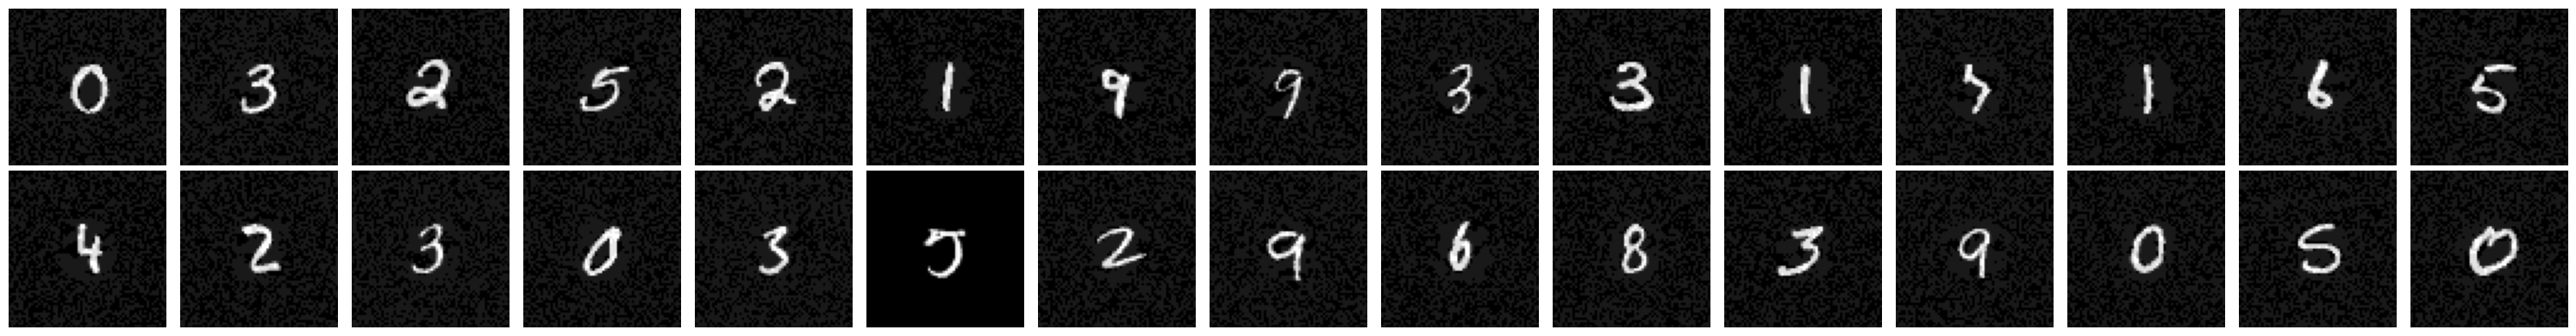

ANN Test Accuracy: 72.456


In [13]:
data_loader = mnist_test_loader
pertubation_strength = 0.1

_X, _y = GenerateAdvExamples(ANN, data_loader, img_size=img_size, epsilon=pertubation_strength)

pertubated_mnist_dataset = TensorDataset(_X, _y)
pertubated_mnist_loader = DataLoader(pertubated_mnist_dataset, batch_size=data_loader.batch_size, shuffle=False)

print('Pertubated Data')
Sample_X = torch.zeros((30, img_size, img_size))
for idx, (X, y) in enumerate(pertubated_mnist_loader):
    if idx == 30:
        break
    Sample_X[idx] = X[random.randint(0, 29)]
    
displaySeq(Sample_X)


# ANN Pertubated Test Accuracy
OrdinEval(ANN, ANN_Params, test_loader=pertubated_mnist_loader)

Normalizing... Done
Network_SNN(
  (fc1): Linear(in_features=4096, out_features=1200, bias=False)
  (HalfRect1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1200, out_features=800, bias=False)
  (HalfRect2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=800, out_features=10, bias=False)
  (HalfRect3): ReLU()
)
 ********** Data Preview **********
torch.Size([64, 30, 64, 64])


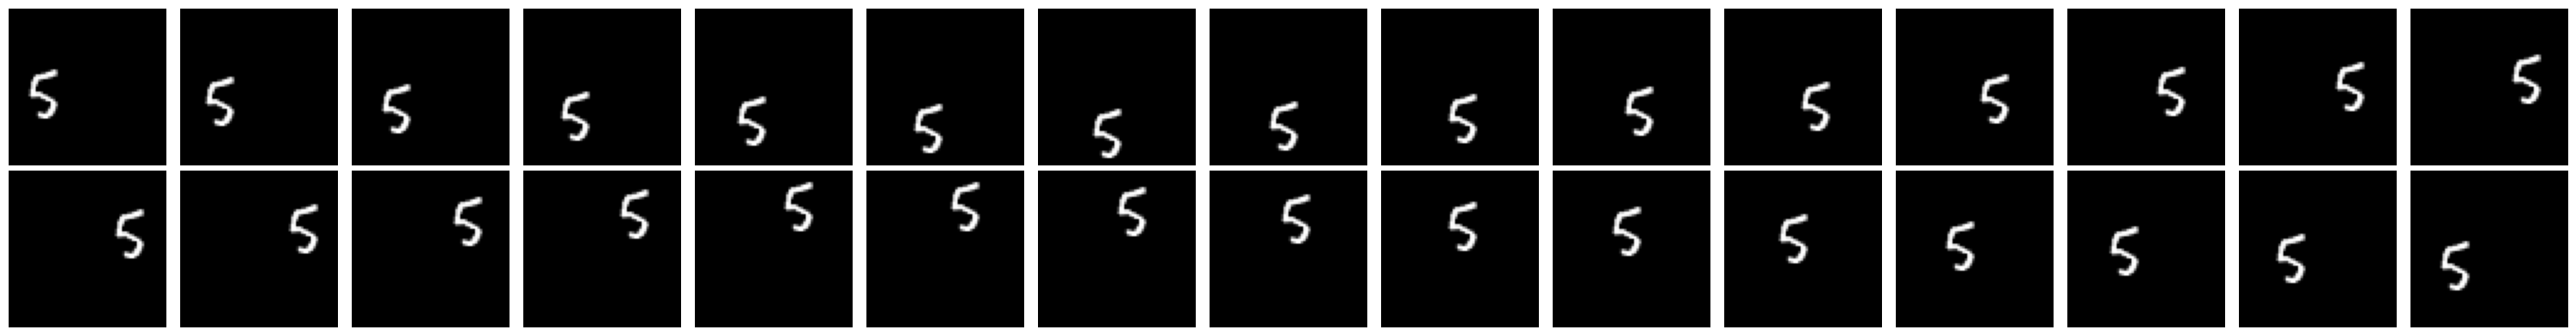

 ********** SNN Training **********
Epoch [1/5], Step [450/2250], Training Loss: 36.65216 Time elasped:44.48 s
Epoch [1/5], Step [900/2250], Training Loss: 30.66790 Time elasped:86.64 s
Epoch [1/5], Step [1350/2250], Training Loss: 28.40325 Time elasped:128.94 s
Epoch [1/5], Step [1800/2250], Training Loss: 27.13028 Time elasped:171.58 s
Epoch [1/5], Step [2250/2250], Training Loss: 26.48289 Time elasped:213.72 s
SNN Test Accuracy: 62.030
Epoch [2/5], Step [450/2250], Training Loss: 25.67021 Time elasped:42.94 s
Epoch [2/5], Step [900/2250], Training Loss: 25.48930 Time elasped:85.27 s
Epoch [2/5], Step [1350/2250], Training Loss: 24.91524 Time elasped:127.70 s
Epoch [2/5], Step [1800/2250], Training Loss: 24.56966 Time elasped:169.92 s
Epoch [2/5], Step [2250/2250], Training Loss: 24.07353 Time elasped:211.96 s
SNN Test Accuracy: 64.661
Epoch [3/5], Step [450/2250], Training Loss: 24.01571 Time elasped:42.82 s
Epoch [3/5], Step [900/2250], Training Loss: 23.92032 Time elasped:85.95 s


In [14]:
time_window = 30
max_rate = 800

batch_size = 64
num_batches = 2250
num_epochs = 5


SNN = Network_SNN(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim,
    time_window=time_window, max_rate=max_rate
)
SNN.to(device)

Normalized_ANN = ANN.normalize_nn(mnist_train_loader)
SNN.load_state_dict(Normalized_ANN.state_dict())

MovingMNIST = BouncingMNISTDataHandler(batch_size=batch_size, seq_length=time_window, image_size=img_size,
                                      path='/kaggle/input/mnist-h5/mnist.h5')

SNN_Params = {
    'seq_length' : time_window, 'num_batches' : num_batches, 'num_epochs' : num_epochs,
    'optimizer' : optim.Adam(SNN.parameters()), 'criterion' : nn.MSELoss().to(device),
    'infer_type' : 'Synth', 'best_acc' : 0
}


SynthTrainNEval(MovingMNIST, SNN, SNN_Params, verbose_interval=5)


 ********** Data Preview **********
torch.Size([128, 30, 64, 64])


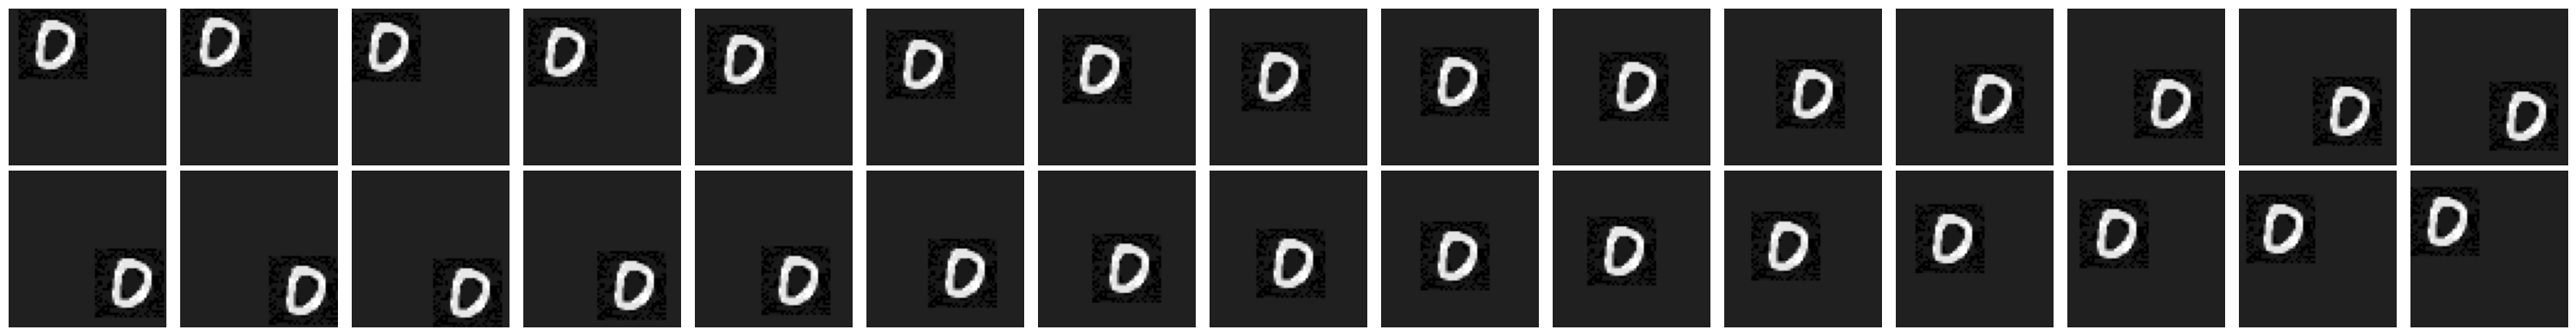

SNN Test Accuracy: 12.198


In [15]:
attack_info = {
    'model' : ANN,
    'data_loader' : data_loader,
    'pertubation_strength' : pertubation_strength,
    'raw' : True
}

PertubatedMovingMNIST = BouncingMNISTDataHandler(batch_size=attack_info['data_loader'].batch_size, seq_length=time_window,
                                                 image_size=img_size, pertubation=True, attack_info=attack_info)


# SNN Pertubated Test Accuracy
SynthEval(PertubatedMovingMNIST, SNN, SNN_Params, data_preview=True)